# Two Rectangles or Triangles

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Data Generation

In [77]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size = 2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x + width, y:y + height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size = 2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]

imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

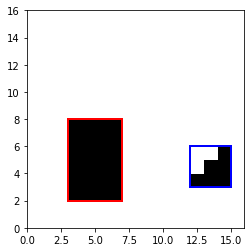

In [78]:
i = 1
plt.imshow(imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
for bbox, shape in zip(bboxes[i], shapes[i]):
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], lw = 2, ec = 'r' if shape[0] == 0 else 'b', fc = 'none'))

## Preprocessing

In [79]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), 3.058442388237381e-17, 1.000000000000001)

In [80]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis = -1).reshape(-1, 10)
y.shape, np.mean(y), np.std(y)

((50000, 10), 0.349913375, 0.27457913305386)

y = bboxes.reshape(num_imgs, -1) / img_size 
y.shape, np.mean(y), np.std(y)

## Train Test Split

In [81]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

## Model

In [82]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
model = Sequential([
        Dense(256, input_dim = X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.5), 
        Dense(y.shape[-1])
        ])
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 256)               65792     
_________________________________________________________________
activation_6 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                2570      
Total params: 68,362
Trainable params: 68,362
Non-trainable params: 0
_________________________________________________________________


## IoU Calculating Function

In [83]:
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

## Distance Calculating Function

In [84]:
def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

## Training

In [92]:
# Flip bboxes during training.
num_epochs = 50
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))
mses = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, epochs = 1, validation_data = (test_X, test_y), verbose = 1, 
              callbacks = [ModelCheckpoint('Two_Rectangles_or_Triangles_model.h5', 
                                           monitor = 'val_loss',
                                           save_best_only = True)])
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[5:], exp_bboxes[:5]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[0:4], exp_bboxes[0:4]) + IOU(pred_bboxes[5:9], exp_bboxes[5:9])
        iou_flipped = IOU(pred_bboxes[0:4], flipped_exp_bboxes[0:4]) + IOU(pred_bboxes[5:9], flipped_exp_bboxes[5:9])
        
        dist = distance(pred_bboxes[0:4], exp_bboxes[0:4]) + IOU(pred_bboxes[5:9], exp_bboxes[5:9])
        dist_flipped = distance(pred_bboxes[0:4], flipped_exp_bboxes[0:4]) + IOU(pred_bboxes[5:9], flipped_exp_bboxes[5:9])
        
        if iou_flipped > iou:  
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
            mses[i, epoch] = mse_flipped / 2.
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            mses[i, epoch] = mse / 2.
            
    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses[:, epoch])))

Epoch 0
1250/1250 [==============================] - 1s 997us/step - loss: 0.0456 - val_loss: 0.0417
Flipped 19222.0 training samples (48.055 %)
Mean IOU: 0.2741845205816994
Mean dist: 0.22284639510366228
Mean mse: 0.019772051942956802
Epoch 1
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0423 - val_loss: 0.0440
Flipped 8426.0 training samples (21.065 %)
Mean IOU: 0.3187232970523486
Mean dist: 0.2464609109747542
Mean mse: 0.017099472894582732
Epoch 2
1250/1250 [==============================] - 1s 986us/step - loss: 0.0392 - val_loss: 0.0458
Flipped 5700.0 training samples (14.249999999999998 %)
Mean IOU: 0.347357065932537
Mean dist: 0.25062559034000625
Mean mse: 0.015201399476725544
Epoch 3
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0369 - val_loss: 0.0479
Flipped 4633.0 training samples (11.5825 %)
Mean IOU: 0.3794344227946986
Mean dist: 0.262117099803486
Mean mse: 0.01389579953976677
Epoch 4
1250/1250 [==============================] - 1s

1250/1250 [==============================] - 1s 1ms/step - loss: 0.0263 - val_loss: 0.0559
Flipped 1764.0 training samples (4.41 %)
Mean IOU: 0.46681888093547813
Mean dist: 0.286106808820883
Mean mse: 0.008425597399424414
Epoch 36
1250/1250 [==============================] - 1s 953us/step - loss: 0.0261 - val_loss: 0.0560
Flipped 1673.0 training samples (4.1825 %)
Mean IOU: 0.45159318669454207
Mean dist: 0.27835448135947316
Mean mse: 0.008443608771069052
Epoch 37
1250/1250 [==============================] - 1s 986us/step - loss: 0.0259 - val_loss: 0.0556
Flipped 1486.0 training samples (3.7150000000000003 %)
Mean IOU: 0.4621580491994794
Mean dist: 0.28314066314035735
Mean mse: 0.008447201113116533
Epoch 38
1250/1250 [==============================] - 1s 1ms/step - loss: 0.0260 - val_loss: 0.0557
Flipped 1618.0 training samples (4.045 %)
Mean IOU: 0.45388050722707873
Mean dist: 0.2809018183779106
Mean mse: 0.008572877457303887
Epoch 39
1250/1250 [==============================] - 1s 1ms

## Flipping Track

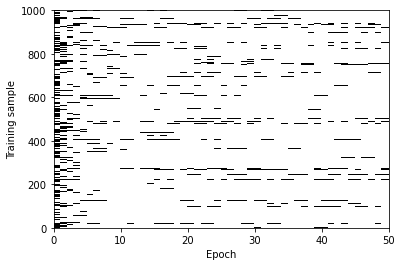

In [93]:
plt.pcolor(flipped[:1000], cmap = 'Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.savefig('two-rectangles-or-triangles_flips.png', dpi = 100)

## Metrics Track

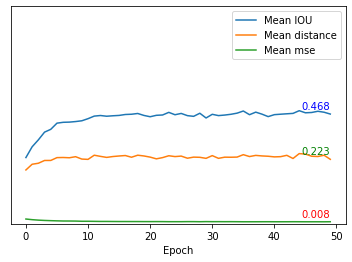

In [94]:
mean_ious_epoch = np.mean(ious, axis = 0)
mean_dists_epoch = np.mean(dists, axis = 0)
mean_mses_epoch = np.mean(mses, axis = 0)
plt.plot(np.mean(ious, axis = 0), label = 'Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis = 0), label = 'Mean distance')  # relative to image size
plt.plot(np.mean(mses, axis = 0), label = 'Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch) - 1, mean_ious_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch) - 1, mean_dists_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch) - 1, mean_mses_epoch[-1] + 0.02), horizontalalignment = 'right', color = 'r')

plt.xlabel('Epoch')
# Hide y tick
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

plt.legend()
plt.ylim(0, 0.9)
plt.savefig('training_metrics.png', dpi = 100)

## Denormalize Data

In [95]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 1))

## Visualize Results

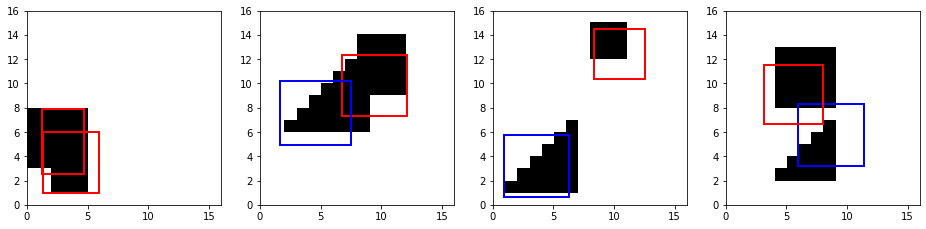

In [108]:
plt.figure(figsize = (16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap = 'Greys', interpolation = 'none', origin = 'lower', extent = [0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], lw = 2, ec = 'r' if pred_shape[0] <= 0.5 else 'b', fc = 'none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
        # plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')

plt.savefig('two-rectangles-or-triangles.png', dpi = 100)

## Overall Assessment

In [109]:
from keras.models import load_model
model_test = load_model('Two_Rectangles_or_Triangles_model.h5')
pred_y = model_test.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
summed_IOU = 0.
for pred_bbox, test_bbox in zip(pred_bboxes.reshape(-1, 4), test_bboxes.reshape(-1, 4)):
    summed_IOU += IOU(pred_bbox, test_bbox)
mean_IOU = summed_IOU / len(pred_bboxes)
mean_IOU

0.15768882794951197